## kNN introduction:

K Nearest Neighbor (KNN from now on) is one of those algorithms that are very simple to understand but works incredibly well in practice. Also it is surprisingly versatile and its applications range from vision to proteins to computational geometry to graphs and so on .

**KNN is an non parametric lazy learning algorithm.** That is a pretty concise statement. When you say a technique is **non parametric** , it means that it does not make any assumptions on the underlying data distribution. This is pretty useful , as in the real world , most of the practical data does not obey the typical theoretical assumptions made (eg gaussian mixtures, linearly separable etc) . Non parametric algorithms like KNN come to the rescue here.

It is also a **lazy algorithm**. What this means is that it does not use the training data points to do any generalization. In other words, there is no explicit training phase or it is very minimal. This means the training phase is pretty fast . Lack of generalization means that KNN keeps all the training data. More exactly, all the training data is needed during the testing phase. (Well this is an exaggeration, but not far from truth). This is in contrast to other techniques like SVM where you can discard all non support vectors without any problem.  Most of the lazy algorithms – especially KNN – makes decision based on the entire training data set (in the best case a subset of them).

The dichotomy is pretty obvious here – **There is a non existent or minimal training phase but a costly testing phase.** The cost is in terms of both time and memory. More time might be needed as in the worst case, all data points might take point in decision. More memory is needed as we need to store all training data.

### Assumptions in KNN
Before using KNN, let us revisit some of the assumptions in KNN.

KNN assumes that the data is in a feature space. More exactly, the data points are in a metric space. The data can be scalars or possibly even multidimensional vectors. Since the points are in feature space, they have a notion of distance – This need not necessarily be Euclidean distance although it is the one commonly used.

Each of the training data consists of a set of vectors and class label associated with each vector. In the simplest case , it will be either + or – (for positive or negative classes). But KNN , can work equally well with arbitrary number of classes.

We are also given a single number "k" . This number decides how many neighbors (where neighbors is defined based on the distance metric) influence the classification. This is usually a odd number if the number of classes is 2. If k=1 , then the algorithm is simply called the nearest neighbor algorithm.


### KNN for Density Estimation

Although classification remains the primary application of KNN, we can use it to do density estimation also. Since KNN is non parametric, it can do estimation for arbitrary distributions. The idea is very similar to use of [Parzen window](http://en.wikipedia.org/wiki/Parzen_window) . Instead of using hypercube and kernel functions, here we do the estimation as follows – For estimating the density at a point x, place a hypercube centered at x and keep increasing its size till k neighbors are captured. Now estimate the density using the formula,

<p>
        <img src = "assets/1.png">
</p>


Where n is the total number of V is the volume of the hypercube. Notice that the numerator is essentially a constant and the density is influenced by the volume. The intuition is this : Lets say density at x is very high. Now, we can find k points near x very quickly . These points are also very close to x (by definition of high density). This means the volume of hypercube is small and the resultant density is high. Lets say the density around x is very low. Then the volume of the hypercube needed to encompass k nearest neighbors is large and consequently, the ratio is low.

The volume performs a job similar to the bandwidth parameter in kernel density estimation. In fact , KNN is one of common methods to estimate the bandwidth (eg adaptive mean shift) .

<p>
        <img src = "assets/2.png">
</p>

<p>
        <img src = "assets/3.png">
</p>

<p>
        <img src = "assets/4.png" width = 300px height = 300px>
        <img src = "assets/5.png" width = 300px height = 300px>
</p>

## Code sample 1: kNN using sklearn + scratch

In [18]:
from sklearn import datasets
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
# define column names
names = [
  'sepal_length',
  'sepal_width',
  'petal_length',
  'petal_width',
  'class',
]

# load training data
df = pd.read_csv('iris.data', header=None, names=names)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
from sklearn.model_selection import train_test_split

# create design matrix X and target vector y
X = np.array(df.iloc[:, 0:4])  # end index is exclusive
y = np.array(df['class'])    # another way of indexing a pandas df

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
print("accuracy: {}".format(accuracy_score(y_test, pred)))

accuracy: 0.98


### Parameter Tuning with Cross Validation

Obviously, the best K is the one that corresponds to the lowest test error rate, so let’s suppose we carry out repeated measurements of the test error for different values of K. Inadvertently, what we are doing is using the test set as a training set! This means that we are underestimating the true error rate since our model has been forced to fit the test set in the best possible manner. Our model is then incapable of generalizing to newer observations, a process known as overfitting. Hence, touching the test set is out of the question and must only be done at the very end of our pipeline.

`Using the test set for hyperparameter tuning can lead to overfitting.`

An alternative and smarter approach involves estimating the test error rate by holding out a subset of the training set from the fitting process. This subset, called the `validation set`, can be used to select the appropriate level of flexibility of our algorithm! There are different validation approaches that are used in practice, and we will be exploring one of the more popular ones called k-fold cross validation.

<p>
        <img src = "assets/6.png" width = 700px height = 700px>
</p>

As seen in the image, k-fold cross validation (the k is totally unrelated to K) involves randomly dividing the training set into k groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining k−1 folds. The misclassification rate is then computed on the observations in the held-out fold. This procedure is repeated k times; each time, a different group of observations is treated as a validation set. This process results in k estimates of the test error which are then averaged out.

`Cross-validation can be used to estimate the test error associated with a learning method in order to evaluate its performance, or to select the appropriate level of flexibility.`


In [12]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# creating odd list of k for kNN
neighbors = list(range(1, 50, 2))

# holding cv scores
cv_scores = []

# perform 10 fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn, X_train, y_train, cv=10, scoring = 'accuracy')
    cv_scores.append(score.mean())

The optimal number of neighbors is 1


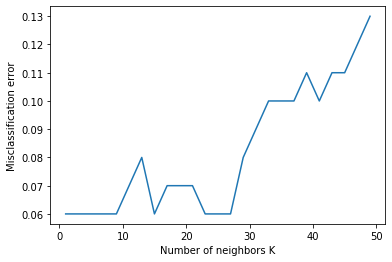

In [13]:
# changing to misclassification error
mse = [1-x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print(f"The optimal number of neighbors is {optimal_k}")

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of neighbors K")
plt.ylabel("Misclassification error")
plt.show()

### 10-fold cross validation tells us that `K=1` results in the lowest validation error.

## kNN from scratch

A machine learning algorithm usually consists of 2 main blocks:

- a **training block** that takes as input the training data X and the corresponding target y and outputs a learned model h.

- a **predict block** that takes as input new and unseen observations and uses the function h to output their corresponding responses.

In the case of KNN, which as discussed earlier, is a lazy algorithm, the training block reduces to just memorizing the training data. Let’s go ahead a write a python method that does so.

In [14]:
def train(X_train, y_train):
    # do nothing
    return

Now we need to write the predict method which must do the following: it needs to compute the euclidean distance between the “new” observation and all the data points in the training set. It must then select the K nearest ones and perform a majority vote. It then assigns the corresponding label to the observation.

In [19]:
def predict(X_train, y_train, x_test, k):
    distances = []
    targets = []
    
    for i in range(len(X_train)):
        distances.append([np.sqrt(np.sum(np.square(x_test - X_train[i,:]))), i])
    
    distances = sorted(distances)
    
    # make a list of the k neighbors targets
    for i in range(k):
        index = distances[i][1]
        targets.append(y_train[index])
    
    # return most common target
    return Counter(targets).most_common(1)[0][0]
    

In the above code, we create an array of distances which we sort by increasing order. That way, we can grab the K nearest neighbors (first K distances), get their associated labels which we store in the targets array, and finally perform a majority vote using a Counter.

Putting it all together, we can define the function k_nearest_neighbor, which loops over every test example and makes a prediction.

In [23]:
def kNearestNeighbors(X_train, y_train, X_test, k):
    # check if k larger than n
    assert k <= len(X_train), "[!] k can't be larger than number of samples."
    
    train(X_train, y_train)
    
    # loop over all observations
    predictions = []
    
    for i in range(len(X_test)):
        predictions.append(predict(X_train, y_train, X_test[i, :], k))
    
    return np.asarray(predictions)

In [24]:
# making our predictions
predictions = kNearestNeighbors(X_train, y_train, X_test, 7)

# evaluating accuracy
accuracy = accuracy_score(y_test, predictions)
print("The accuracy of our classifier is {}".format(accuracy))

The accuracy of our classifier is 0.98


### Pros and Cons of KNN

**Pros:** As you can already tell from the previous section, one of the most attractive features of the K-nearest neighbor algorithm is that is simple to understand and easy to implement. With zero to little training time, it can be a useful tool for off-the-bat analysis of some data set you are planning to run more complex algorithms on. Furthermore, KNN works just as easily with multiclass data sets whereas other algorithms are hardcoded for the binary setting. Finally, as we mentioned earlier, the non-parametric nature of KNN gives it an edge in certain settings where the data may be highly “unusual”.

**Cons:** One of the obvious drawbacks of the KNN algorithm is the computationally expensive testing phase which is impractical in industry settings. Note the rigid dichotomy between KNN and the more sophisticated Neural Network which has a lengthy training phase albeit a very fast testing phase. Furthermore, KNN can suffer from skewed class distributions. For example, if a certain class is very frequent in the training set, it will tend to dominate the majority voting of the new example (large number = more common). Finally, the accuracy of KNN can be severely degraded with high-dimension data because there is little difference between the nearest and farthest neighbor.

## REFERENCES:

- [knn scratch](https://kraj3.com.np/blog/2019/06/implementation-of-knn-from-scratch-in-python/)
- [knn from scratch](https://dataaspirant.com/2016/12/27/k-nearest-neighbor-algorithm-implementaion-python-scratch/)
- [Mail spam or not - kNN](https://anujkatiyal.com/blog/2017/10/01/ml-knn/#.XrZCVnUzZuQ)
- [kNN in depth analysis](https://tomaszgolan.github.io/introduction_to_machine_learning/markdown/introduction_to_machine_learning_01_knn/introduction_to_machine_learning_01_knn/)
- [kNN numpy NYC](https://nycdatascience.com/blog/student-works/machine-learning/knn-classifier-from-scratch-numpy-only/)
- [Maths kNN](http://www.datascribble.com/blog/machine-learning/understanding-math-behind-knn-codes-python/)
- [A Complete Guide to K-Nearest-Neighbors with Applications in Python and R](https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/)
- [kNN tds1](https://towardsdatascience.com/knn-k-nearest-neighbors-1-a4707b24bd1d)
- [KNN ALGORITHM AND IMPLEMENTATION FROM SCRATCH]()
- [Knn](https://medium.com/datadriveninvestor/knn-algorithm-and-implementation-from-scratch-b9f9b739c28f)
- [kNN from scratch](https://towardsdatascience.com/lets-make-a-knn-classifier-from-scratch-e73c43da346d)
- [kNN numpy scratch](https://towardsdatascience.com/k-nearest-neighbors-classification-from-scratch-with-numpy-cb222ecfeac1)
- [ML basics with kNN](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)
- [A Detailed Introduction to K-Nearest Neighbor (KNN) Algorithm](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/)
- []()